In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)

In [3]:
dataframe = pandas.read_csv('covid_19_india.csv')
dataframe.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [4]:
dataset = dataframe.values
dataset

array([[1, '30/01/20', '6:00 PM', ..., 0, 0, 1],
       [2, '31/01/20', '6:00 PM', ..., 0, 0, 1],
       [3, '01/02/20', '6:00 PM', ..., 0, 0, 2],
       ...,
       [1867, '12/05/20', '8:00 AM', ..., 46, 1, 68],
       [1868, '12/05/20', '8:00 AM', ..., 1758, 80, 3573],
       [1869, '12/05/20', '8:00 AM', ..., 499, 190, 2063]], dtype=object)

In [5]:
dataframe = dataframe.drop(['State/UnionTerritory', 'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Deaths'], axis=1)
dataframe.head()

,Sno,Date,Time,Confirmed
0,1,30/01/20,6:00 PM,1
1,2,31/01/20,6:00 PM,1
2,3,01/02/20,6:00 PM,2
3,4,02/02/20,6:00 PM,3
4,5,03/02/20,6:00 PM,3


In [6]:
dataframe['Date'] = dataframe['Date'] + '20'
dataframe

,Sno,Date,Time,Confirmed
0,1,30/01/2020,6:00 PM,1
1,2,31/01/2020,6:00 PM,1
2,3,01/02/2020,6:00 PM,2
3,4,02/02/2020,6:00 PM,3
4,5,03/02/2020,6:00 PM,3
...,...,...,...,...
1864,1865,12/05/2020,8:00 AM,1275
1865,1866,12/05/2020,8:00 AM,152
1866,1867,12/05/2020,8:00 AM,68
1867,1868,12/05/2020,8:00 AM,3573


In [7]:
dataframe['DateTime'] = dataframe['Date'] + ' ' + dataframe['Time']
dataframe

,Sno,Date,Time,Confirmed,DateTime
0,1,30/01/2020,6:00 PM,1,30/01/2020 6:00 PM
1,2,31/01/2020,6:00 PM,1,31/01/2020 6:00 PM
2,3,01/02/2020,6:00 PM,2,01/02/2020 6:00 PM
3,4,02/02/2020,6:00 PM,3,02/02/2020 6:00 PM
4,5,03/02/2020,6:00 PM,3,03/02/2020 6:00 PM
...,...,...,...,...,...
1864,1865,12/05/2020,8:00 AM,1275,12/05/2020 8:00 AM
1865,1866,12/05/2020,8:00 AM,152,12/05/2020 8:00 AM
1866,1867,12/05/2020,8:00 AM,68,12/05/2020 8:00 AM
1867,1868,12/05/2020,8:00 AM,3573,12/05/2020 8:00 AM


In [8]:
dataframe = dataframe.drop(['Date', 'Time'], axis=1)
dataframe.head()

,Sno,Confirmed,DateTime
0,1,1,30/01/2020 6:00 PM
1,2,1,31/01/2020 6:00 PM
2,3,2,01/02/2020 6:00 PM
3,4,3,02/02/2020 6:00 PM
4,5,3,03/02/2020 6:00 PM


In [9]:
dataframe = dataframe.drop(['Sno'], axis=1)
dataframe

,Confirmed,DateTime
0,1,30/01/2020 6:00 PM
1,1,31/01/2020 6:00 PM
2,2,01/02/2020 6:00 PM
3,3,02/02/2020 6:00 PM
4,3,03/02/2020 6:00 PM
...,...,...
1864,1275,12/05/2020 8:00 AM
1865,152,12/05/2020 8:00 AM
1866,68,12/05/2020 8:00 AM
1867,3573,12/05/2020 8:00 AM


In [10]:
len(dataframe)

1869

In [11]:
dataframe['DateTime'] = pandas.to_datetime(dataframe['DateTime'], format='%d/%m/%Y %H:%M %p').dt.strftime('%Y-%m-%d %H:%M:%S')
dataframe

,Confirmed,DateTime
0,1,2020-01-30 06:00:00
1,1,2020-01-31 06:00:00
2,2,2020-02-01 06:00:00
3,3,2020-02-02 06:00:00
4,3,2020-02-03 06:00:00
...,...,...
1864,1275,2020-05-12 08:00:00
1865,152,2020-05-12 08:00:00
1866,68,2020-05-12 08:00:00
1867,3573,2020-05-12 08:00:00


In [12]:
gdf = dataframe.groupby('DateTime')
data = []
for name, df in gdf:
    print(name)
    s = sum(df['Confirmed'].astype(float))
    data.append([s])
data

2020-01-30 06:00:00
2020-01-31 06:00:00
2020-02-01 06:00:00
2020-02-02 06:00:00
2020-02-03 06:00:00
2020-02-04 06:00:00
2020-02-05 06:00:00
2020-02-06 06:00:00
2020-02-07 06:00:00
2020-02-08 06:00:00
2020-02-09 06:00:00
2020-02-10 06:00:00
2020-02-11 06:00:00
2020-02-12 06:00:00
2020-02-13 06:00:00
2020-02-14 06:00:00
2020-02-15 06:00:00
2020-02-16 06:00:00
2020-02-17 06:00:00
2020-02-18 06:00:00
2020-02-19 06:00:00
2020-02-20 06:00:00
2020-02-21 06:00:00
2020-02-22 06:00:00
2020-02-23 06:00:00
2020-02-24 06:00:00
2020-02-25 06:00:00
2020-02-26 06:00:00
2020-02-27 06:00:00
2020-02-28 06:00:00
2020-02-29 06:00:00
2020-03-01 06:00:00
2020-03-02 06:00:00
2020-03-03 06:00:00
2020-03-04 06:00:00
2020-03-05 06:00:00
2020-03-06 06:00:00
2020-03-07 06:00:00
2020-03-08 06:00:00
2020-03-09 06:00:00
2020-03-10 06:00:00
2020-03-11 06:00:00
2020-03-12 06:00:00
2020-03-13 06:00:00
2020-03-14 06:00:00
2020-03-15 06:00:00
2020-03-16 06:00:00
2020-03-17 06:00:00
2020-03-18 06:00:00
2020-03-19 06:00:00


[[1.0],
 [1.0],
 [2.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [3.0],
 [5.0],
 [6.0],
 [28.0],
 [30.0],
 [31.0],
 [34.0],
 [39.0],
 [46.0],
 [58.0],
 [60.0],
 [74.0],
 [81.0],
 [84.0],
 [110.0],
 [114.0],
 [137.0],
 [151.0],
 [173.0],
 [223.0],
 [283.0],
 [360.0],
 [433.0],
 [519.0],
 [606.0],
 [694.0],
 [724.0],
 [909.0],
 [1024.0],
 [1251.0],
 [1397.0],
 [1834.0],
 [2069.0],
 [2547.0],
 [3072.0],
 [3577.0],
 [4281.0],
 [4789.0],
 [5274.0],
 [5865.0],
 [6761.0],
 [7529.0],
 [8447.0],
 [9352.0],
 [10815.0],
 [11933.0],
 [12759.0],
 [13835.0],
 [14792.0],
 [16116.0],
 [17656.0],
 [18985.0],
 [20471.0],
 [21700.0],
 [23452.0],
 [24893.0],
 [26605.0],
 [28160.0],
 [29834.0],
 [31709.0],
 [33330.0],
 [34972.0],
 [37157.0],
 [40124.0],
 [42836.0],
 [46711.0],
 [49391.0],
 [52952.0],
 [56342.0],
 [59662.0],
 

In [13]:
len(data)

104

In [14]:
dataset = numpy.array(data)
dataset.shape

(104, 1)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(104, 1)

In [16]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)
test.shape

72 32
(72, 1)


(32, 1)

In [17]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    c = 0
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        c+=1
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [18]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(70, 1)
(70,)
(30, 1)
(30,)


In [19]:
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = numpy.reshape(testX, (testX.shape[0], look_back, 1))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(70, 1, 1)
(70,)
(30, 1, 1)
(30,)


In [20]:
model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 1s - loss: 3.5951e-04 - accuracy: 0.0143
Epoch 2/200
 - 0s - loss: 3.4389e-04 - accuracy: 0.0143
Epoch 3/200
 - 0s - loss: 3.3345e-04 - accuracy: 0.0143
Epoch 4/200
 - 0s - loss: 3.1720e-04 - accuracy: 0.0143
Epoch 5/200
 - 0s - loss: 3.1122e-04 - accuracy: 0.0143
Epoch 6/200
 - 0s - loss: 2.8473e-04 - accuracy: 0.0143
Epoch 7/200
 - 0s - loss: 2.7984e-04 - accuracy: 0.0143
Epoch 8/200
 - 0s - loss: 2.6846e-04 - accuracy: 0.0143
Epoch 9/200
 - 0s - loss: 2.4929e-04 - accuracy: 0.0143
Epoch 10/200
 - 0s - loss: 2.3672e-04 - accuracy: 0.0143
Epoch 11/200
 - 0s - loss: 2.2898e-04 - accuracy: 0.0143
Epoch 12/200
 - 0s - loss: 2.1322e-04 - accuracy: 0.0143
Epoch 13/200
 - 0s - loss: 1.8831e-04 - accuracy: 0.0143
Epoch 14/200
 - 0s - loss: 1.7770e-04 - accuracy: 0.0143
Epoch 15/200
 - 0s - loss: 1.5832e-04 - accuracy: 0.0143
Epoch 16/200
 - 0s - loss: 1.3688e-04 - accuracy: 0.0143
Epoch 17/200
 - 0s - loss: 1.2607e-04 - accuracy: 0.0143
Epoch 18/200
 - 0s - loss: 1.0076e-04 - 

 - 0s - loss: 1.6282e-06 - accuracy: 0.0143
Epoch 145/200
 - 0s - loss: 1.2232e-06 - accuracy: 0.0143
Epoch 146/200
 - 0s - loss: 1.4782e-06 - accuracy: 0.0143
Epoch 147/200
 - 0s - loss: 2.6793e-06 - accuracy: 0.0143
Epoch 148/200
 - 0s - loss: 1.9190e-06 - accuracy: 0.0143
Epoch 149/200
 - 0s - loss: 1.9663e-06 - accuracy: 0.0143
Epoch 150/200
 - 0s - loss: 1.5316e-06 - accuracy: 0.0143
Epoch 151/200
 - 0s - loss: 1.3282e-06 - accuracy: 0.0143
Epoch 152/200
 - 0s - loss: 1.4261e-06 - accuracy: 0.0143
Epoch 153/200
 - 0s - loss: 1.9055e-06 - accuracy: 0.0143
Epoch 154/200
 - 0s - loss: 1.2043e-06 - accuracy: 0.0143
Epoch 155/200
 - 0s - loss: 1.4278e-06 - accuracy: 0.0143
Epoch 156/200
 - 0s - loss: 1.4976e-06 - accuracy: 0.0143
Epoch 157/200
 - 0s - loss: 1.8438e-06 - accuracy: 0.0143
Epoch 158/200
 - 0s - loss: 1.4179e-06 - accuracy: 0.0143
Epoch 159/200
 - 0s - loss: 2.0397e-06 - accuracy: 0.0143
Epoch 160/200
 - 0s - loss: 1.5000e-06 - accuracy: 0.0143
Epoch 161/200
 - 0s - loss: 

In [21]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 64.49 RMSE
Test Score: 3619.31 RMSE


In [22]:
testY

array([[ 8447.,  9352., 10815., 11933., 12759., 13835., 14792., 16116.,
        17656., 18985., 20471., 21700., 23452., 24893., 26605., 28160.,
        29834., 31709., 33330., 34972., 37157., 40124., 42836., 46711.,
        49391., 52952., 56342., 59662., 62939., 67152.]])

In [23]:
testPredict

array([[ 8646.318],
       [ 9690.854],
       [10717.342],
       [12368.562],
       [13622.442],
       [14543.806],
       [15736.974],
       [16790.9  ],
       [18236.71 ],
       [19898.9  ],
       [21315.129],
       [22877.227],
       [24151.088],
       [25937.242],
       [27378.906],
       [29058.172],
       [30550.871],
       [32122.213],
       [33837.457],
       [35281.598],
       [36707.42 ],
       [38546.6  ],
       [40937.6  ],
       [43016.547],
       [45813.473],
       [47631.387],
       [49904.754],
       [51924.234],
       [53771.805],
       [55475.582]], dtype=float32)

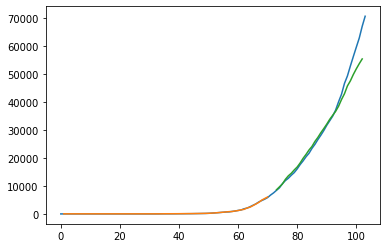

In [24]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()